In [7]:
import cv2
import numpy as np
import imutils
from ultralytics import YOLO
import math
import torch
import json

In [8]:
def draw_centroids_on_image(output_image, json_results):   
    data = json.loads(json_results) # Converting JSON array to Python List
    # Accessing each individual object and then getting its xmin, ymin, xmax and ymax to calculate its centroid
    for objects in data:
        xmin = objects["xmin"]
        ymin = objects["ymin"]
        xmax = objects["xmax"]
        ymax = objects["ymax"]
        
        #print("Object: ", data.index(objects))
        #print ("xmin", xmin)
        #print ("ymin", ymin)
        #print ("xmax", xmax)
        #print ("ymax", ymax)
        
        #Centroid Coordinates of detected object
        cx = int((xmin+xmax)/2.0)
        cy = int((ymin+ymax)/2.0)   
        #print(cx,cy)
    
        cv2.circle(output_image, (cx,cy), 2, (0, 0, 255), 2, cv2.FILLED) #draw center dot on detected object
        cv2.putText(output_image, str(str(cx)+" , "+str(cy)), (int(cx)-40, int(cy)+30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

    return (output_image)

Using cache found in C:\Users\Abhim/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-1-16 Python-3.10.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


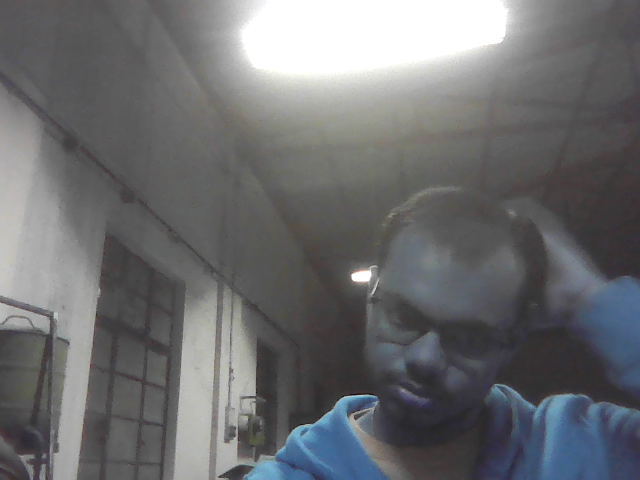

image 1/1: 480x640 (no detections)
Speed: 1.5ms pre-process, 12.6ms inference, 20.2ms NMS per image at shape (1, 3, 480, 640)
tensor([], device='cuda:0', size=(0, 6))
[tensor([], device='cuda:0', size=(0, 6))]


AttributeError: 'numpy.ndarray' object has no attribute 'flush'

In [9]:
cap = cv2.VideoCapture(1)
cap.set(3, 640)
cap.set(4, 480)

model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5\yolov5m_25epochs.pt')
model.eval()
model.classes = [0]
classNames = ['arrow','not arrow']
while True:
    ret, video = cap.read()
    
    results = model(video)
    results.show()
    print (results)
    print (results.xyxy[0])
    print (results.xyxy)

    json_results = results.pandas().xyxy[0].to_json(orient="records") # im predictions (JSON)
    results.render()  # updates results.imgs with boxes and labels                    
    output_image = results.ims[0] #output image after rendering // results.ims is correct (not results.imgs)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)           
    output_image = draw_centroids_on_image(output_image, json_results) # Draw Centroids on the deteted objects and returns updated imag
    video = output_image
    video = cv2.imread(video)
    video = cv2.GaussianBlur(video, (11,11), 0)
    gray = cv2.cvtColor(video,cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,7,0.01,10)
    corners = np.int0(corners)

    ct='a'
    for i in corners:
        x,y = i.ravel()
        print(x,y)
        cv2.circle(img,(x,y),3,(255,255,0),-1)
        cv2.putText(img, ct, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA )
        ct=ct+'a'

    xmax, ymax = (np.max(corners, axis = 0)).ravel()
    xmin, ymin = (np.min(corners, axis = 0)).ravel() 

   
    if( abs(xmax-xmin) > abs(ymax-ymin)):
        if(np.count_nonzero(corners[:,0,0] == xmax) == 2):
            dir = 0
            print(dir)
        else:
            dir = 1
            print(dir)
    else:
        if(np.count_nonzero(corners[:,0,1] == ymax) == 2):
            dir = 2
            print(dir)
        else:
            dir = 3
            print(dir)   

    cv2.imshow('image',video)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()